In [30]:
!pip3 install pandas

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [31]:

# Read In Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

goalies_df = pd.read_csv('Goalies.csv', on_bad_lines='skip')
teams_df = pd.read_csv('Teams.csv')

In [32]:
# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name',
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG',
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG',
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y',
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]


Dataset Shape: (1490, 17)

Missing Values:
year                 0
tmID                 0
G                    0
Pts                  0
GF                   0
GA                   0
GP                   0
Min                  0
SHO                  0
SA                   0
PIM                110
PPG                418
PPC                419
PKG                418
PKC                419
SavePercentage     686
GoalsAgainstAvg      1
dtype: int64

Summary Statistics:
              year            G          Pts           GF           GA  \
count  1490.000000  1490.000000  1490.000000  1490.000000  1490.000000   
mean   1973.818121    69.275168    70.884564   218.649664   218.619463   
std      28.527716    19.812845    26.333096    78.587100    79.866188   
min    1909.000000     1.000000     0.000000     4.000000     8.000000   
25%    1956.000000    70.000000    53.000000   174.000000   172.000000   
50%    1980.000000    80.000000    75.000000   228.000000   228.500000   
75%    1997.0

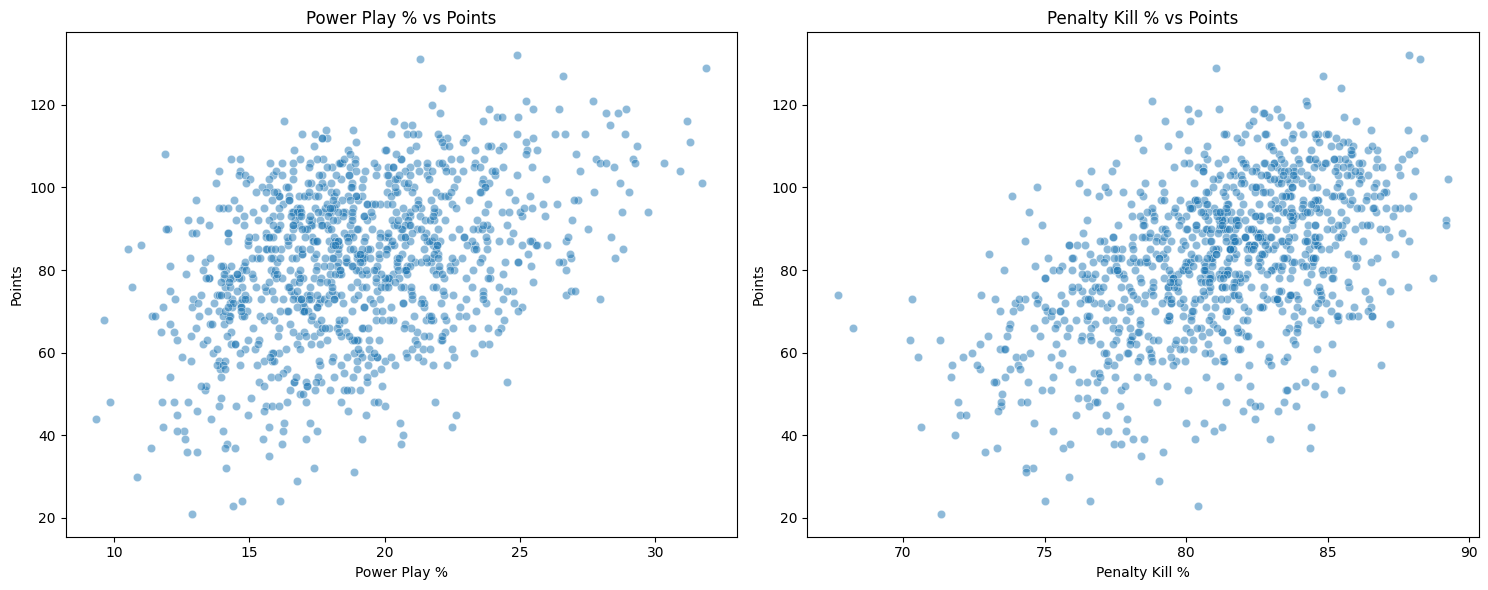


Correlations with Points:
Power Play %: 0.394
Penalty Kill %: 0.486

Summary Statistics:

Power Play Percentage:
count    1071.000000
mean       19.042225
std         3.843574
min         9.348442
25%        16.354895
50%        18.732782
75%        21.538128
max        31.877729
Name: PowerPlayPercentage, dtype: float64

Penalty Kill Percentage:
count    1071.000000
mean       80.998570
std         3.659204
min        67.697595
25%        78.526680
50%        81.350482
75%        83.714098
max        89.250814
Name: PKPercentage, dtype: float64

Top 5 Teams by Power Play Percentage:
     year tmID  PowerPlayPercentage  Pts
666  1977  MTL            31.877729  129
608  1975  NYI            31.724138  101
668  1977  NYI            31.277533  111
695  1978  NYI            31.153846  116
613  1975  QUN            30.923695  104

Top 5 Teams by Penalty Kill Percentage:
      year tmID  PKPercentage  Pts
1169  1999  DAL     89.250814  102
1133  1997  WAS     89.196676   92
1135  1998  BOS 

In [33]:
# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# 6. Display summary statistics and check for missing values
print("\nDataset Shape:", team_stats.shape)
print("\nMissing Values:")
print(team_stats.isnull().sum())
print("\nSummary Statistics:")
print(team_stats.describe())

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# Clean NaN and infinite values before modeling
print(f"\nOriginal number of rows: {len(X)}")

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]

print(f"Number of rows after removing NaN/infinite values: {len(X)}")
print(f"Removed {len(team_stats) - len(X)} rows")

# Create multiple visualizations for special teams analysis
query1 = team_stats.copy()
query1['PowerPlayPercentage'] = (query1['PPG'] / query1['PPC']) * 100
query1['PKPercentage'] = ((query1['PKC'] - query1['PKG']) / query1['PKC']) * 100

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# 1. Power Play % vs Points
plt.subplot(1, 2, 1)
sns.scatterplot(data=query1, x='PowerPlayPercentage', y='Pts', alpha=0.5)
plt.title('Power Play % vs Points')
plt.xlabel('Power Play %')
plt.ylabel('Points')

# 2. Penalty Kill % vs Points
plt.subplot(1, 2, 2)
sns.scatterplot(data=query1, x='PKPercentage', y='Pts', alpha=0.5)
plt.title('Penalty Kill % vs Points')
plt.xlabel('Penalty Kill %')
plt.ylabel('Points')

plt.tight_layout()
plt.show()

# Print correlations
pp_corr = query1['PowerPlayPercentage'].corr(query1['Pts'])
pk_corr = query1['PKPercentage'].corr(query1['Pts'])
print("\nCorrelations with Points:")
print(f"Power Play %: {pp_corr:.3f}")
print(f"Penalty Kill %: {pk_corr:.3f}")

# Calculate some summary statistics
print("\nSummary Statistics:")
print("\nPower Play Percentage:")
print(query1['PowerPlayPercentage'].describe())
print("\nPenalty Kill Percentage:")
print(query1['PKPercentage'].describe())

# Show teams with best PP% and PK%
print("\nTop 5 Teams by Power Play Percentage:")
print(query1.nlargest(5, 'PowerPlayPercentage')[['year', 'tmID', 'PowerPlayPercentage', 'Pts']])

print("\nTop 5 Teams by Penalty Kill Percentage:")
print(query1.nlargest(5, 'PKPercentage')[['year', 'tmID', 'PKPercentage', 'Pts']])


In [34]:
# Prepare data
X = query1[['PowerPlayPercentage', 'PKPercentage']]
y = query1['Pts']

# Clean NaN and infinite values before modeling
print(f"\nOriginal number of rows: {len(X)}")

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]

print(f"Number of rows after removing NaN/infinite values: {len(X)}")
print(f"Removed {len(query1) - len(X)} rows")



Original number of rows: 1490
Number of rows after removing NaN/infinite values: 1071
Removed 419 rows


R2 Score: 0.453
RMSE: 13.889

Coefficients:
Power Play %: 2.343
Penalty Kill %: 2.884

Additional Models Comparison:
--------------------------------------------------

Ridge Regression:
R2 Score: 0.453
RMSE: 13.889
5-Fold CV R2 Score: 0.318 (+/- 0.612)
Coefficients:
Power Play %: 2.343
Penalty Kill %: 2.883

Lasso Regression:
R2 Score: 0.452
RMSE: 13.900
5-Fold CV R2 Score: 0.318 (+/- 0.610)
Coefficients:
Power Play %: 2.261
Penalty Kill %: 2.797

Random Forest:
R2 Score: 0.324
RMSE: 15.442
5-Fold CV R2 Score: 0.144 (+/- 0.608)

SVR:
R2 Score: 0.447
RMSE: 13.968
5-Fold CV R2 Score: 0.333 (+/- 0.501)


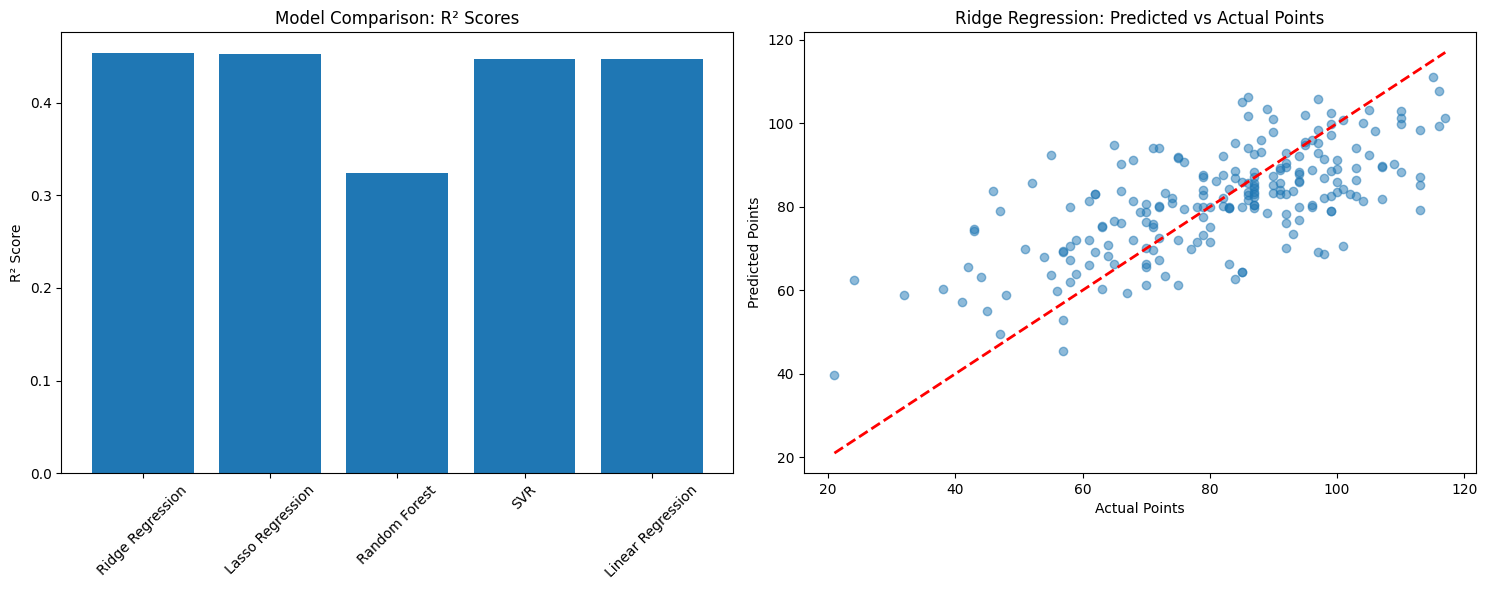

In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Print coefficients
print("\nCoefficients:")
print(f"Power Play %: {model.coef_[0]:.3f}")
print(f"Penalty Kill %: {model.coef_[1]:.3f}")

# Additional Models Comparison
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Dictionary to store additional models
additional_models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='linear')
}

# Train and evaluate each additional model
print("\nAdditional Models Comparison:")
print("-" * 50)
for name, model in additional_models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    print(f"\n{name}:")
    print(f"R2 Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"5-Fold CV R2 Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Print coefficients only for linear models (Ridge and Lasso)
    if isinstance(model, (Ridge, Lasso)):
        print("Coefficients:")
        print(f"Power Play %: {model.coef_[0]:.3f}")
        print(f"Penalty Kill %: {model.coef_[1]:.3f}")

# Create visualizations for model comparison
plt.figure(figsize=(15, 6))

# 1. Model R² Scores Comparison
plt.subplot(1, 2, 1)
model_names = list(additional_models.keys()) + ['Linear Regression']
r2_scores = [r2_score(y_test, model.predict(X_test)) for model in additional_models.values()]
r2_scores.append(r2_score(y_test, y_pred))  # Add Linear Regression score

plt.bar(model_names, r2_scores)
plt.title('Model Comparison: R² Scores')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

# 2. Best Model (Ridge) Predictions vs Actual
plt.subplot(1, 2, 2)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

plt.scatter(y_test, ridge_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Ridge Regression: Predicted vs Actual Points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

plt.tight_layout()
plt.show()


